In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import matplotlib.pyplot as plt
import statistics 
from statistics import mode
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

In [2]:
# Create a model with 1 hidden layer whose size is taken as input
class Net_H(nn.Module):
    def __init__(self,size,H_size):
        super(Net_H, self).__init__()
        self.fc1 = nn.Linear(size,H_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(H_size,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [3]:
# Create a model with 2 hidden layers H1 and H2 whose sizes are taken as input
class Net_2Layer(nn.Module):
    def __init__(self,size,H_size,H2_size):
        super(Net_2Layer, self).__init__()
        self.fc1 = nn.Linear(size,H_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(H_size,H2_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(H2_size,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [4]:
''' 
This function is called to train one epoch using batch sizes based on the batch size, 
the data is being split and then provided for training based on which the loss is
calculated 
'''
def train_epoch(model, opt, criterion, batch_size=100):
    model.train()
    losses = []
    for index in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[index:index + batch_size, :]
        label_batch = labels[index:index + batch_size, :]
        opt.zero_grad()
        prediction = model(x_batch)
        loss = criterion(prediction,label_batch)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    losses = sum(losses)/len(losses)
    return losses

In [5]:
'''
For baseline prediction for the testing data, we just randomly predict 0 and 1 for the
length of the testing data 5 times. Then we ge the maximum of the 5 for each value and 
then get the baseline prediction using that as the prediction
'''
def baselinePrediction(output1):
    predictions_array=[]
    for i in range(5):
        test=np.random.randint(2, size=len(x_test))
        test = list(test)
        predictions_array.append(test)
    predictions_array = np.array(predictions_array)
    print(predictions_array.shape)
    final_prediction =np.zeros(predictions_array.shape[1])
    for i in range(predictions_array.shape[1]):
        temp_list=predictions_array[:,i].tolist()
        final_prediction[i]=mode(temp_list)
    count=0
    for i in range(output1.shape[0]):
        if(output1[i]==final_prediction[i]):
            count = count+1
    print("Baseline accuracy is ", (count/final_prediction.shape[0])*100)
    return (count/final_prediction.shape[0])*100

In [6]:
'''
Get the testing accuracy and keeping the threshold as 0.5 to convert it to 0 or 1 
as the output is a sigmoid function(probablity)
'''
def testingAccuracy(model,x_test,output1):
    predictions_array=[]
    model = model.eval()
    with torch.no_grad():
        predictions = model(x_test)
    test = np.asarray(predictions)
    
    test[test>0.5]=1
    test[test<=0.5]=0

    count=0
    for i in range(test.shape[0]):
        if(output1[i]==test[i]):
            count = count+1
    print("Accuracy is ", (count/test.shape[0])*100)
    return (count/test.shape[0])*100

In [7]:
#change the dataframe to numpy array to tensor array
def changeToTensor(dataFrame):
    dataFrame= (dataFrame-dataFrame.min())/(dataFrame.max()-dataFrame.min())
    x = dataFrame.values
    x= x.astype('float64')
    x= torch.Tensor(x)
    return x

In [8]:
def preProcess(data):
    data_numpy = data.values
    labels = data_numpy[:,-1]
    labels= labels.astype('float64')
    data_numpy = data.drop(['date','Occupancy'],axis=1)
    features = changeToTensor(data_numpy)
    return features, labels

In [9]:
num_epochs = 100

In [10]:
criteria= nn.BCELoss()

In [11]:
train_data = pd.read_csv('train.txt',sep=',')
test_data = pd.read_csv('test.txt',sep=',')

In [12]:
train_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [13]:
x_train, labels =preProcess(train_data)
labels_accuracy = labels
labels= torch.Tensor(labels)
labels = labels.unsqueeze(1)
print(x_train.shape, labels.shape)

torch.Size([8143, 5]) torch.Size([8143, 1])


In [14]:
x_test, output = preProcess(test_data)

### Part (a) printing the loss value across 100 epochs for batch training

In [15]:
model = Net_H(x_train.shape[1],5)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
loss_to_plot_batch=[]
for e in range(num_epochs):
    e_losses = train_epoch(model,optimizer ,criteria,x_train.shape[0]) # set the batch size as the entire training data
    loss_to_plot_batch.append(e_losses)
    print("For epoch ",e+1,"loss is ",e_losses)

For epoch  1 loss is  0.662053644657135
For epoch  2 loss is  0.6614029407501221
For epoch  3 loss is  0.6607487797737122
For epoch  4 loss is  0.6601080894470215
For epoch  5 loss is  0.6594626307487488
For epoch  6 loss is  0.6588321924209595
For epoch  7 loss is  0.658207356929779
For epoch  8 loss is  0.6575844883918762
For epoch  9 loss is  0.6569613814353943
For epoch  10 loss is  0.6563491225242615
For epoch  11 loss is  0.6557418704032898
For epoch  12 loss is  0.6551352143287659
For epoch  13 loss is  0.6545279622077942
For epoch  14 loss is  0.6539378762245178
For epoch  15 loss is  0.6533477306365967
For epoch  16 loss is  0.6527562141418457
For epoch  17 loss is  0.6521687507629395
For epoch  18 loss is  0.651583194732666
For epoch  19 loss is  0.6510065793991089
For epoch  20 loss is  0.6504350304603577
For epoch  21 loss is  0.6498570442199707
For epoch  22 loss is  0.6492881774902344
For epoch  23 loss is  0.6487239003181458
For epoch  24 loss is  0.6481524109840393
For 

### Part (b) Getting the baseline accuracy for the testing data from randomly generated labels

In [17]:
baseline_accuracy = baselinePrediction(output)

(5, 9752)
Baseline accuracy is  49.887202625102546


In [18]:
baseline_error= 1-(baseline_accuracy/100)
baseline_error_plot=[baseline_error]*100 # this is used to plot the baseline error 

### Part (c) With the H=5, mini batch as 100 and plotted training loss across every epoch

In this a learning rate scheduler is used which reduces the lr from 0.01 by a factor of 0.1 across every 10 epochs.<br>
Also, the training of the moel was stopped when a local minimum was reached( i.e when thed difference between the consequtive losses was less than 0.0001 and also as the loss was continuously decreasing). <br>
Also, the training accuracy was observed as 97.45. Testing accuracy was observed as 98.45<br>
Also, it is noted that the training loss across epochs went lower than the baseline error

Stopped running at  26  epochs rather than 100 epochs
Accuracy for the testing data 
Accuracy is  98.24651353568498

Accuracy for the training data
Accuracy is  97.45793933439765


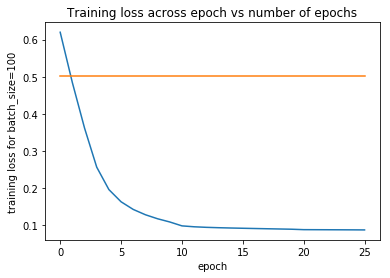

In [19]:
num_epochs = 100
e_losses=[]
loss_across_epoch=[]
model = Net_H(x_train.shape[1],5)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
for e in range(num_epochs):
    e_losses = train_epoch(model,optimizer ,criteria,100)
    scheduler.step()
    if(len(loss_across_epoch)>1):
        if(loss_across_epoch[-1]-e_losses)<0.0001:
            num_epochs=e
        else:
            loss_across_epoch.append(e_losses)
    else:
        loss_across_epoch.append(e_losses)
        
print("Stopped running at ",len(loss_across_epoch)," epochs rather than 100 epochs")
print("Accuracy for the testing data ")
dummy=testingAccuracy(model,x_test,output)
print()
print("Accuracy for the training data")
dummy=testingAccuracy(model,x_train,labels_accuracy)#train_numpy[:,-1].astype('float64'))
plt.title('Training loss across epoch vs number of epochs')
plt.plot(loss_across_epoch)
baseline_error_plot1 = baseline_error_plot[:len(loss_across_epoch)]
plt.plot(baseline_error_plot1)
plt.xlabel('epoch')
plt.ylabel('training loss for batch_size=100')
plt.show()

### Part (d) Plot of the training loss obtained by considering the entire training data as a batch

For the batchGD of batch_size=100, the loss is a curve that decreased and then became almost constant.<br>
The loss for the batch_size= len(training_size), the loss continuously decreases for all of the 100 epochs.

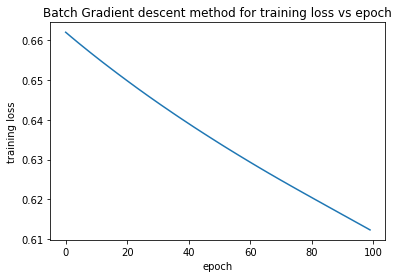

In [20]:
plt.title('Batch Gradient descent method for training loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(loss_to_plot_batch)

### Part (e) Varied the number of hidden layers(H) and created a model for each of it and plotted the training and testing error

This also uses the scheduler which starts from  0.1 and reduces by a factor of 0.1 for every 10 epochs.This also has the early stopping instead of running all the epochs.
Also, for various values of the hidden node size, the training and testing accuracy are plotted which varies every time for every run of the cell. 

Stopped running at  27  epochs rather than 100 epochs

Training accuracy for H  1
Accuracy is  21.232960825248682
Testing accuracy for H  1
Accuracy is  21.011074651353567

Stopped running at  24  epochs rather than 100 epochs

Training accuracy for H  2
Accuracy is  21.232960825248682
Testing accuracy for H  2
Accuracy is  21.011074651353567

Stopped running at  26  epochs rather than 100 epochs

Training accuracy for H  5
Accuracy is  78.76703917475132
Testing accuracy for H  5
Accuracy is  78.98892534864643

Stopped running at  32  epochs rather than 100 epochs

Training accuracy for H  10
Accuracy is  82.62311187523026
Testing accuracy for H  10
Accuracy is  80.10664479081214

Stopped running at  26  epochs rather than 100 epochs

Training accuracy for H  20
Accuracy is  78.76703917475132
Testing accuracy for H  20
Accuracy is  78.98892534864643



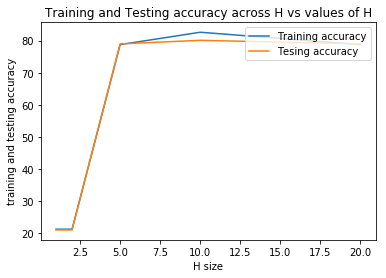

In [21]:
x_axis=[1,2,5,10,20]
training_accuracy_every_H=[]
testing_accuracy_every_H=[]
for H in [1,2,5,10,20]:
    loss_across_epoch=[]
    num_epochs=100
    model = Net_H(x_train.shape[1],H)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    for e in range(num_epochs):
        e_losses = train_epoch(model,optimizer ,criteria,x_train.shape[0])
        scheduler.step()
        if(len(loss_across_epoch)>1):
            if(loss_across_epoch[-1]-e_losses)<0.0001:
                num_epochs=e
            else:
                loss_across_epoch.append(e_losses)
        else:
            loss_across_epoch.append(e_losses)
    print("Stopped running at ",len(loss_across_epoch)," epochs rather than 100 epochs")
    print()
    print("Training accuracy for H ",H)
    training_accuracy_every_H.append(testingAccuracy(model,x_train,labels_accuracy))#train_numpy[:,-1].astype('float64')))
    print("Testing accuracy for H ",H)
    testing_accuracy_every_H.append(testingAccuracy(model,x_test,output))
    print()
plt.title('Training and Testing accuracy across H vs values of H')
plt.plot(x_axis,training_accuracy_every_H)
plt.plot(x_axis,testing_accuracy_every_H)
plt.legend(['Training accuracy','Tesing accuracy'], loc='upper right')
plt.xlabel('H size')
plt.ylabel('training and testing accuracy')
plt.show()

### Part (f) Changed the BCELoss to MSELoss and performed the training and testing again

With MSE loss on the sigmoid output(0-1), the loss is very less compared to when using the BCELoss because it squares the difference which would be very less whereas the BCELoss takes log in the calculation.<br>
It can be seen that the loss values are really less than compared to when the BCELoss was being used.
 

In [22]:
criteria= nn.MSELoss()
num_epochs=100

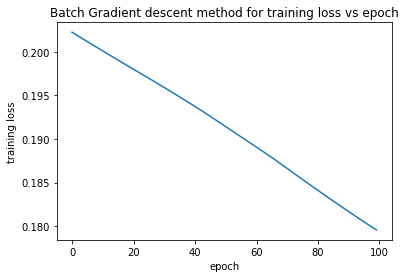

In [23]:
model = Net_H(x_train.shape[1],5)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_to_plot_batch=[]
for e in range(num_epochs):
    e_losses = train_epoch(model,optimizer ,criteria,x_train.shape[0])
    loss_to_plot_batch.append(e_losses)
plt.title('Batch Gradient descent method for training loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(loss_to_plot_batch)

In [24]:
# for param in model.parameters ():
#     print(param.data)

Criteria is  MSELoss()
Stopped running at  26  epochs instead of 100
Accuracy is  98.77973748974568
Accuracy for the training data
Accuracy is  98.31757337590568


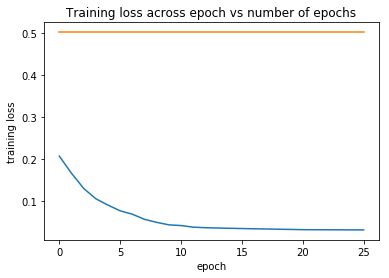

In [25]:
print("Criteria is ",criteria)
e_losses=[]
loss_across_epoch=[]
model = Net_H(x_train.shape[1],5)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
for e in range(num_epochs):
    e_losses = train_epoch(model,optimizer ,criteria,100)
    scheduler.step()
    if(len(loss_across_epoch)>1):
        if(loss_across_epoch[-1]-e_losses)<0.0001:
            num_epochs=e
        else:
            loss_across_epoch.append(e_losses)
    else:
        loss_across_epoch.append(e_losses)
print("Stopped running at ",len(loss_across_epoch)," epochs instead of 100")



dummy=testingAccuracy(model,x_test,output)
print("Accuracy for the training data")
dummy=testingAccuracy(model,x_train,labels_accuracy)#train_numpy[:,-1].astype('float64'))
plt.title('Training loss across epoch vs number of epochs')

plt.plot(loss_across_epoch)    
baseline_error_plot1 = baseline_error_plot[:len(loss_across_epoch)]
plt.plot(baseline_error_plot1)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

Stopped running at  23  epochs rather than 100 epochs

Training accuracy for H  1
Accuracy is  21.232960825248682
Testing accuracy for H  1
Accuracy is  21.011074651353567

Stopped running at  23  epochs rather than 100 epochs

Training accuracy for H  2
Accuracy is  78.81616111998035
Testing accuracy for H  2
Accuracy is  81.72682526661198

Stopped running at  24  epochs rather than 100 epochs

Training accuracy for H  5
Accuracy is  21.232960825248682
Testing accuracy for H  5
Accuracy is  21.011074651353567

Stopped running at  24  epochs rather than 100 epochs

Training accuracy for H  10
Accuracy is  21.232960825248682
Testing accuracy for H  10
Accuracy is  21.011074651353567

Stopped running at  23  epochs rather than 100 epochs

Training accuracy for H  20
Accuracy is  78.76703917475132
Testing accuracy for H  20
Accuracy is  78.98892534864643



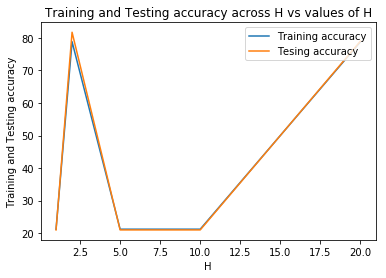

In [26]:
x_axis=[1,2,5,10,20]
training_accuracy_every_H=[]
testing_accuracy_every_H=[]
for H in [1,2,5,10,20]:
    loss_across_epoch=[]
    num_epochs=100
    model = Net_H(x_train.shape[1],H)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    for e in range(num_epochs):
        e_losses = train_epoch(model,optimizer ,criteria,x_train.shape[0])
        scheduler.step()
        if(len(loss_across_epoch)>1):
            if(loss_across_epoch[-1]-e_losses)<0.0001:
                num_epochs=e
            else:
                loss_across_epoch.append(e_losses)
        else:
            loss_across_epoch.append(e_losses)
    print("Stopped running at ",len(loss_across_epoch)," epochs rather than 100 epochs")
    print()
    print("Training accuracy for H ",H)
    training_accuracy_every_H.append(testingAccuracy(model,x_train,labels_accuracy))#train_numpy[:,-1].astype('float64')))
    print("Testing accuracy for H ",H)
    testing_accuracy_every_H.append(testingAccuracy(model,x_test,output))
    print()
plt.title('Training and Testing accuracy across H vs values of H')
plt.plot(x_axis,training_accuracy_every_H)
plt.plot(x_axis,testing_accuracy_every_H)
plt.legend(['Training accuracy','Tesing accuracy'], loc='upper right')
plt.xlabel('H')
plt.ylabel('Training and Testing accuracy')
plt.show()

### Part(g) Created a two layer network and obtained the test accuracy for every combination for H1 and H2

For this part, a new network was created which had varying sizes of the H1 and H2. <br>
From this output, we can clearly see that, more the neurons in a model, the better the performance.
<br>For example, when the model was created as 5-1-15-1, the testing and training accuracy was 86 and 95<br>
Whereas in the case of 5-20-230-1, the testing and training accuracies were 96.933 and 98.722
<br> <br> Also, since the model weights depend on their initialization for training, we see that sometimes that model with almost same size like 5-20-120-1 had better testing accurracy of 99.056.(Got it once)
Om running multiple times, these values are bound to change too. 

In [27]:
num_epochs=100
criteria= nn.BCELoss()
for H1 in [1,2,5,10,20]:
    for H2 in [15,120,220,230]:
        print()
        print("H1 has ",H1,' neurons and H2 has',H2,' neurons')
        model = Net_2Layer(x_train.shape[1],H1,H2)
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
        for e in range(num_epochs):
            e_losses = train_epoch(model,optimizer ,criteria,x_train.shape[0])
        print("Testing accuracy for the 2 layer for the model with H1 ",H1," and H2 ",H2)
        testingAccuracy(model,x_test,output)
        print("Training accuracy for the same model ")
        testingAccuracy(model,x_train,labels_accuracy)


H1 has  1  neurons and H2 has 15  neurons
Testing accuracy for the 2 layer for the model with H1  1  and H2  15
Accuracy is  88.1870385561936
Training accuracy for the same model 
Accuracy is  91.71067174260101

H1 has  1  neurons and H2 has 120  neurons
Testing accuracy for the 2 layer for the model with H1  1  and H2  120
Accuracy is  86.54634946677605
Training accuracy for the same model 
Accuracy is  95.80007368291784

H1 has  1  neurons and H2 has 220  neurons
Testing accuracy for the 2 layer for the model with H1  1  and H2  220
Accuracy is  91.65299425758818
Training accuracy for the same model 
Accuracy is  98.28073191698391

H1 has  1  neurons and H2 has 230  neurons
Testing accuracy for the 2 layer for the model with H1  1  and H2  230
Accuracy is  97.29286300246103
Training accuracy for the same model 
Accuracy is  98.61230504727988

H1 has  2  neurons and H2 has 15  neurons
Testing accuracy for the 2 layer for the model with H1  2  and H2  15
Accuracy is  85.73625922887614